# Replicating Fig. 5.35

"V1 mechanisms and some figure–ground and border effects" Zhaoping, 2003:

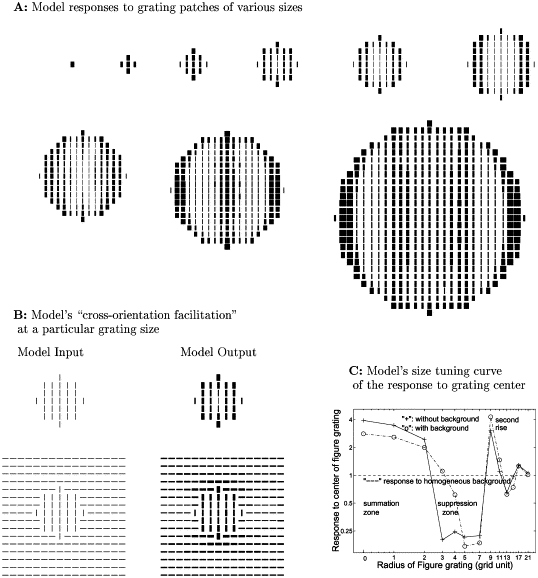

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

from v1sh_model.inputs.visualize import visualize_input, visualize_output
from v1sh_model.models.V1_model_1 import V1_model_1 as V1_model

In [ ]:
# Instantiate and test the FullModel
seed = 42
model = V1_model(seed=seed, alpha_x=1.0, alpha_y=1.0)
T = 12 
dt = 0.01

In [ ]:
def grating_disc(diameter = 1, n_image = 4, I_input = 3.5, surround = False):
    A = np.zeros((n_image, n_image))
    C = np.zeros((n_image, n_image))
    
    if n_image % 2 == 1:
        middle = int((n_image - 1) / 2)
        x = np.arange(- middle, middle + 1, 1)
    else:
        middle = n_image / 2
        x = np.arange(- middle, middle, 1)
    X, Y = np.meshgrid(x, x)
    R = np.sqrt(X**2 + Y**2)
    mask = (R <= diameter / 2)
    C[mask] = I_input
    
    if surround: 
        A[~mask] = np.pi / 2  # horizontal grating in center
        C[~mask] = I_input 
    
    return A, C

In [ ]:
X_gens = {}
X_gens_with_surround = {}
for d in [0, 2, 4, 6, 8, 10, 16, 20, 26]:
    A, C = grating_disc(diameter=d, n_image = d + 40, I_input=3.5)
    X_gen, Y_gen, I = model.simulate(
        A, C, dt=dt, T=T, verbose=False, noisy=False, mode="wrap")
    X_gens[d] = X_gen
    
    # with surround
    A_s, C_s = grating_disc(diameter=d, n_image = d + 40, I_input=3.5, surround=True)
    X_gen_s, Y_gen_s, I_s = model.simulate(
        A_s, C_s, dt=dt, T=T, verbose=False, noisy=False, mode="wrap")
    X_gens_with_surround[d] = X_gen_s

In [ ]:
for d, X_gen in X_gens.items():
    model_output = model.g_x(X_gen).mean(axis=0) # N_y x N_x x K
    
    C_out = model_output.max(axis=-1)  # N_y x N_x
    argmax_angle_indices = model_output.argmax(axis=-1)  # N_y x N_x
    A_out = np.pi / model.K * argmax_angle_indices  # N_y x N_x
    
    # cut array to maximal size of non-zero entries
    mask = C_out > 0
    nonzero_row_idxs = np.nonzero(np.any(mask, axis=1))[0]
    min_y, max_y = np.min(nonzero_row_idxs), np.max(nonzero_row_idxs) + 1
    nonzero_col_idxs = np.nonzero(np.any(mask, axis=0))[0]
    min_x, max_x = np.min(nonzero_col_idxs), np.max(nonzero_col_idxs) + 1
    
    visualize_output(A_out[min_y : max_y, min_x : max_x], C_out[min_y : max_y, min_x : max_x] * 2, verbose=False)
    plt.savefig(f"../../docs/figure/medial_axis_effect_2/Fig. 5.35_diameter_{d}.png", dpi=400)

In [ ]:
for d, X_gen in X_gens_with_surround.items():
    model_output = model.g_x(X_gen).mean(axis=0) # N_y x N_x x K
    
    C_out = model_output.max(axis=-1)  # N_y x N_x
    argmax_angle_indices = model_output.argmax(axis=-1)  # N_y x N_x
    A_out = np.pi / model.K * argmax_angle_indices  # N_y x N_x
    
    # cut array to maximal size of non-zero entries
    mask = C_out > 0
    nonzero_row_idxs = np.nonzero(np.any(mask, axis=1))[0]
    min_y, max_y = np.min(nonzero_row_idxs), np.max(nonzero_row_idxs) + 1
    nonzero_col_idxs = np.nonzero(np.any(mask, axis=0))[0]
    min_x, max_x = np.min(nonzero_col_idxs), np.max(nonzero_col_idxs) + 1
    
    visualize_output(A_out[min_y : max_y, min_x : max_x], C_out[min_y : max_y, min_x : max_x] * 2, verbose=False)
    plt.savefig(f"../../docs/figure/medial_axis_effect_2/Fig. 5.35_diameter_{d}_surround.png", dpi=400)

In [ ]:
diameters = []
neural_responses, neural_responses_supressed = [], []
homogeneous_response = []

for d in X_gens.keys():
    diameters.append(d)
    
    assert d % 2 == 0, "Diameter assumed to be even."
    central_idx = 20 + int(d / 2)
    
    model_output = model.g_x(X_gens[d]).mean(axis=0) # N_y x N_x x K
    neural_responses.append(model_output[central_idx, central_idx, 0]) # response of central, vertically tuned neuron 
    
    model_output_s = model.g_x(X_gens_with_surround[d]).mean(axis=0) # N_y x N_x x K
    neural_responses_supressed.append(model_output_s[central_idx, central_idx, 0]) # response of central, vertically tuned neuron
    
    homogeneous_response.append(model.g_x(X_gens_with_surround[d]).mean(axis=0)[0, 0, 6])

print("Homogeneous response", np.mean(homogeneous_response), " +/- ", np.std(homogeneous_response))

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(6,4), dpi=400, constrained_layout=True)
plt.plot(diameters, neural_responses, marker='o', linewidth = 2, label = "No surround")
plt.plot(diameters, neural_responses_supressed, marker='x', linewidth = 2, label = "With surround")
plt.plot(diameters, [np.mean(homogeneous_response)] * len(diameters), linestyle='--', color='gray', label='Response to\nhom. background')
plt.ylim(0., 1.1)
plt.xlim(-1, 27)
plt.xlabel("Diameter of grating disk")
plt.ylabel("Response of central neuron")
plt.title("Modeled summation curve")
plt.legend(loc = "upper right", fontsize=10)
plt.show()

Observations / open questions:
- why is my surround supression region (bewlo grey line) different than hers - input strength?
- why does surround increase the medial axis effect? 
- if I further inc rease fig size, do I find convergence to the gry line?
- do I have boundary artifacts (see pictures)? 